In [1]:
## Import all files
import os
import sys
import re
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from numba import jit
import json


## HELPER CONSTANTS

In [13]:
## Set constants for function uses

np.random.seed(7)

DIR_GLOVE = '../encodings/glove/glove.840B.300d/'
DIR_DATA = '../data/'
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
TEST_SPLIT = 0.1
VALIDATION_SPLIT = 0.1

## HELPER FUNCTIONS

In [14]:
# Apply regex to clean the string
def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

# Uses glove vectorizer for making word embeddings
def gloveVec(filename):
    embeddings = {}
    f = open(os.path.join(filename), encoding='utf-8')
    i = 0
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings[word] = coefs
        except ValueError:
            i += 1
    f.close()
    return embeddings

# Data preprocessing, add labels from dataset
def loadData(filename):
    df = pd.read_csv(DIR_DATA + filename)
    selected = ['label', 'text']
    non_selected = list(set(df.columns) - set(selected))
    df = df.drop(non_selected, axis=1)
    df = df.dropna(axis=0, how='any', subset=selected)
    labels = sorted(list(set(df[selected[0]].tolist())))
    dict.fromkeys(set(df[selected[0]].tolist()))
    label_dict = {}
    for i in range(len(labels)):
        label_dict[labels[i]] = i

    x_train = df[selected[1]].apply(lambda x: clean_str(x)).tolist()
    y_train = df[selected[0]].apply(lambda y: label_dict[y]).tolist()
    y_train = to_categorical(np.asarray(y_train))
    return x_train,y_train,labels

# Tokenizes sentences from the dataset using keras tokenizer
def createVocabAndData(sentences):
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(sentences)
    sequences = tokenizer.texts_to_sequences(sentences)
    vocab = tokenizer.word_index
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    return vocab,data,tokenizer

#Ensures that all sentences have the same length
def oneSentence(sentence, tokenizer):
    sequences = tokenizer.texts_to_sequences(sentence)
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    return sequences,data

# Uses to create vocabulary or Embedding matrix for  dataset
def createEmbeddingMatrix(word_index,embeddings_index):
    nb_words = min(MAX_NB_WORDS, len(word_index))
    embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i > MAX_NB_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [15]:

def lstmModel(embedding_matrix,epoch,no_of_emotions):
    model = Sequential()
    n, embedding_dims = embedding_matrix.shape

    model.add(Embedding(n, embedding_dims, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(LSTM(128, dropout=0.6, recurrent_dropout=0.6))
    model.add(Dense(no_of_emotions))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    model.fit(X_train, y_train, validation_split=VALIDATION_SPLIT, epochs=epoch, batch_size=128)
    model.save_weights('text_lstm_weights.h5')
    model.save('lstm_tweets_model.h5')
    scores= model.evaluate(X_test, y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))
    return model


## Run above functions to create the embeddings

In [ ]:
sentences, labels, label_dict = loadData('tweet_emotions.csv')
f1 = open('../encodings/embedding_matrix.pkl','rb')
data,labels,embedding_mat = pickle.load(f1)
# embeddings = gloveVec('glove/glove.840B.300d.txt')
vocab, data, tokenizer = createVocabAndData(sentences)
# embedding_mat = createEmbeddingMatrix(vocab,embeddings)
no_of_emotions = len(labels[0])



# pickle.dump([data, labels, embedding_mat], open('embedding_matrix.pkl', 'wb'))
print ("Data created")

print("Train Test split")
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=TEST_SPLIT, random_state=42)

In [ ]:
tokenizer_json = tokenizer.to_json()
with open('../movie_sentiment_ml/app/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

## Tokeniser Loader

## TEST OUTPUT & TRAIN MODEL

In [ ]:
# embedding_mat

In [24]:
#embeddings

In [25]:
# vocab

{'i': 1,
 'to': 2,
 'the': 3,
 'a': 4,
 'my': 5,
 'you': 6,
 'it': 7,
 'and': 8,
 'is': 9,
 'in': 10,
 'for': 11,
 "'s": 12,
 'of': 13,
 "n't": 14,
 'that': 15,
 'me': 16,
 'on': 17,
 'have': 18,
 'so': 19,
 'but': 20,
 'just': 21,
 "i'm": 22,
 'day': 23,
 'with': 24,
 'do': 25,
 'be': 26,
 'was': 27,
 'at': 28,
 'not': 29,
 'good': 30,
 'all': 31,
 'this': 32,
 'now': 33,
 'out': 34,
 'up': 35,
 'get': 36,
 'are': 37,
 'like': 38,
 'no': 39,
 'quot': 40,
 'http': 41,
 'go': 42,
 'your': 43,
 'today': 44,
 'love': 45,
 'work': 46,
 'too': 47,
 'got': 48,
 'going': 49,
 'we': 50,
 'happy': 51,
 'what': 52,
 'lol': 53,
 'from': 54,
 'one': 55,
 'time': 56,
 'u': 57,
 'know': 58,
 'back': 59,
 'com': 60,
 'im': 61,
 'will': 62,
 'there': 63,
 'really': 64,
 'am': 65,
 'about': 66,
 'its': 67,
 'see': 68,
 'had': 69,
 'amp': 70,
 'did': 71,
 'can': 72,
 'ca': 73,
 'they': 74,
 'some': 75,
 'night': 76,
 'if': 77,
 'new': 78,
 'home': 79,
 'how': 80,
 'think': 81,
 'well': 82,
 '2': 83,
 't

In [26]:
# data

array([[   0,    0,    0, ...,   28,  184,  543],
       [   0,    0,    0, ...,   17,   43,  292],
       [   0,    0,    0, ..., 4176, 1745,  238],
       ...,
       [   0,    0,    0, ...,    9,   43,   23],
       [   0,    0,    0, ...,   10,    3,  450],
       [   0,    0,    0, ...,  325,  998, 1234]])

In [27]:
# model = lstmModel(embedding_mat,40,no_of_emotions)

In [28]:
# del(embedding_mat,40,no_of_emotions)

In [29]:
# with open('dumped_model.pk', 'wb') as file:
#     pickle.dump(model,file)

## Load saved data

In [16]:
from keras.preprocessing.text import tokenizer_from_json
tokenizer_path = r'D:\Django projects\Movie_recommender_ml\react-movie-frontend-ml\backend\movie_sentiment_ml\app\tokenizer.json'
# tokenizer_path = os.path.join(file_dir,'tokenizer.json')
with open(tokenizer_path) as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

In [17]:
# model.save("lstm_model")
model1 = tf.keras.models.load_model(r"D:\Django projects\Movie_recommender_ml\react-movie-frontend-ml\backend\movie_sentiment_ml\lstm_model")

In [18]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          6000300   
                                                                 
 lstm_1 (LSTM)               (None, 128)               219648    
                                                                 
 dense_1 (Dense)             (None, 13)                1677      
                                                                 
 activation_1 (Activation)   (None, 13)                0         
                                                                 
Total params: 6,221,625
Trainable params: 221,325
Non-trainable params: 6,000,300
_________________________________________________________________


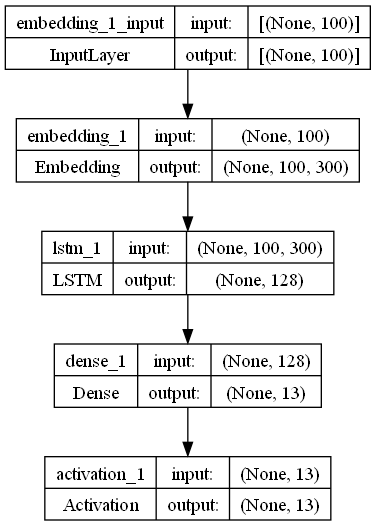

In [19]:
tf.keras.utils.plot_model(
    model1,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

In [20]:
label_dict = ['anger', 'boredom', 'empty', 'enthusiasm', 'fun', 
                  'happiness', 'hate', 'love', 'neutral', 'relief', 
                  'sadness', 'surprise', 'worry']

In [24]:
test_sentence = ["I am feeling a bit low today"]
test_data = oneSentence(test_sentence, tokenizer)

emo = model1.predict(test_data[1])
index = np.argmax(emo)

label_dict[index]

1/1 [==============================] - 0s 143ms/step


'worry'

In [29]:
df =pd.read_csv(r'D:\Django projects\Movie_recommender_ml\temp\backend\data\tweet_emotions.csv')
df['label'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: label, dtype: int64

In [30]:
df =pd.read_csv(r'D:\Django projects\Movie_recommender_ml\temp\backend\data\eng_dataset.csv')
df['label'].value_counts()

fear       2252
anger      1701
joy        1616
sadness    1533
Name: label, dtype: int64